In [2]:
from datetime import timedelta

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras import layers, models

In [3]:
holidays = pd.read_csv("data/holidays_events.csv", parse_dates=["date"])

oil = pd.read_csv("data/oil.csv", index_col="date", parse_dates=["date"])

stores = pd.read_csv("data/stores.csv", index_col="store_nbr")

test = pd.read_csv("data/test.csv", index_col="id", parse_dates=["date"])

train = pd.read_csv("data/train.csv", index_col="id", parse_dates=["date"])

transactions = pd.read_csv(
    "data/transactions.csv",
    index_col=["date", "store_nbr"],
    parse_dates=["date"],
)

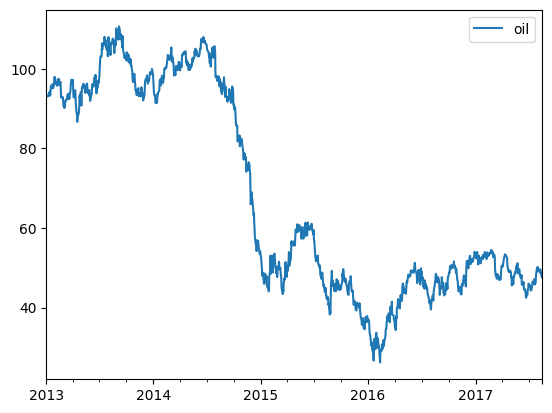

In [11]:
oil = oil.rename(columns={"dcoilwtico": "oil"})
oil = oil.reindex(pd.date_range(train.date.min(), train.date.max()))
oil = oil.interpolate(method="linear", limit_direction="both")
oil.plot.line()
plt.show()

In [5]:
holiday_dates = holidays.loc[
    (holidays.transferred == False) & (holidays.locale == "National")
].date

In [6]:
train["days_since_start"] = (train.date - train.date[0]).dt.days
# train["year"] = train.date.dt.year
train["month"] = train.date.dt.month
# train["day"] = train.date.dt.day
train["dayofweek"] = train.date.dt.dayofweek
train = train.merge(oil, left_on="date", right_index=True, how="left")
train = train.merge(
    stores.add_prefix("store_"), left_on="store_nbr", right_index=True, how="left"
)
train["holiday"] = train.date.isin(holiday_dates.values)

train["mean_sales"] = train.groupby(["store_nbr", "family"]).sales.transform("mean")

train["recent_sales"] = train.groupby(["store_nbr", "family"]).sales.transform(
    lambda x: x.rolling(window=30).mean().shift(15)
)

In [7]:
train_subset = train.dropna()

train_dummies = pd.get_dummies(
    train_subset,
    columns=[
        "family",
        "dayofweek",
        # "month",
        # "store_cluster",
        # "store_type",
    ],
).drop(
    columns=[
        # "family",
        "month",
        "date",
        "store_nbr",
        "store_city",
        "store_state",
        "store_cluster",
        "store_type",
    ]
)

In [8]:
test_selector = train_subset.date >= (train_subset.date.iloc[-1] - timedelta(days=15))

tmp_train = train_dummies.loc[~test_selector]
tmp_test = train_dummies.loc[test_selector]

y_train = tmp_train.sales
y_test = tmp_test.sales

X_train = tmp_train.drop(columns=["sales"]).astype(float)
X_test = tmp_test.drop(columns=["sales"]).astype(float)

In [9]:
num_features = len(X_train.columns)

model = models.Sequential(
    [
        layers.Dense(50, activation="relu", input_shape=(num_features,)),
        layers.Dense(20, activation="relu"),
        layers.Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse")

model.fit(X_train, y_train, epochs=10, batch_size=1000)

print()
model.evaluate(X_test, y_test)

Epoch 1/10
2894/2894 [==============================] - 2s 719us/step - loss: 191585.9219
Epoch 2/10
2894/2894 [==============================] - 2s 705us/step - loss: 176786.6094
Epoch 3/10
2894/2894 [==============================] - 2s 718us/step - loss: 170915.6719
Epoch 4/10
2894/2894 [==============================] - 2s 712us/step - loss: 162832.3438
Epoch 5/10
2894/2894 [==============================] - 2s 703us/step - loss: 154225.0156
Epoch 6/10
2894/2894 [==============================] - 2s 704us/step - loss: 147005.0469
Epoch 7/10
2894/2894 [==============================] - 2s 718us/step - loss: 142247.5312
Epoch 8/10
2894/2894 [==============================] - 2s 714us/step - loss: 137764.9531
Epoch 9/10
2894/2894 [==============================] - 2s 704us/step - loss: 134905.4688
Epoch 10/10
2894/2894 [==============================] - 2s 709us/step - loss: 133443.9219

891/891 [==============================] - 0s 254us/step - loss: 94744.6797


94744.6796875

891/891 [==============================] - 0s 247us/step


<Axes: xlabel='id'>

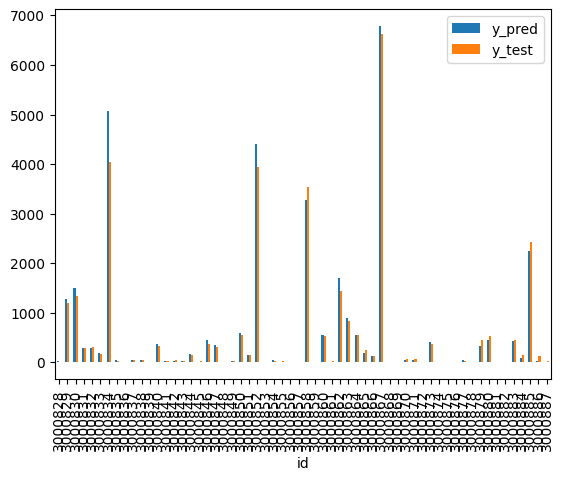

In [10]:
y_pred = model.predict(X_test)
results = pd.DataFrame({"y_pred": y_pred[:, 0], "y_test": y_test})
results.iloc[-60:].plot.bar()